# Imports and data loading

In [ ]:
import os
os.chdir("..")  # when on own machine
# os.chdir("/home2/***/l3_project")  # go to project root for local imports when on NCC

import helpers
import xai

In [2]:
import typing as t

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
AVAILABLE_MODELS = ("ConvNeXtSmall", "ResNet50", "SwinTransformerSmall")

pd.options.display.precision = 5
pd.options.display.max_colwidth = 20
pd.options.display.max_columns = None
pd.options.display.width = 225

plt.style.use('seaborn-v0_8-paper')

## Load data into multi-indexed dataframe

In [4]:
dfs = dict()
for explainer_name in t.get_args(xai.EXPLAINER_NAMES):
    results_for_exp = dict()
    h5_output_path = helpers.env_var.get_project_root() / "results" / explainer_name / "evaluation_output.h5"
    store = pd.HDFStore(str(h5_output_path), mode="r")
    for key_name in store.keys():
        table_name = key_name.strip("/")
        df: pd.DataFrame = store[table_name]
        if df.isna().sum().sum() != 0:
            raise RuntimeError("A results table contains NaN values!")
        else:
            # adjust value in line with methodology formula and updated output_completeness.py
            df["output_completeness : preservation_check_conf_drop"] = 1 - df["output_completeness : preservation_check_conf_drop"]

            results_for_exp[table_name] = df
    dfs[explainer_name] = results_for_exp
    store.close()
for key in dfs.keys():
    print(f"{key}: {len(dfs[key])} tables loaded")

PartitionSHAP: 12 tables loaded
GradCAM: 12 tables loaded
KPCACAM: 12 tables loaded


In [5]:
# ew = pd.ExcelWriter("results/all_results_export.xlsx")
big_df_dict = dict()
for sheet_name, df_dict in dfs.items():
    temp_df = pd.concat(df_dict).reset_index()
    temp_df["dataset"] = temp_df["level_0"].str.split("_").str.get(0)
    temp_df["model"] = temp_df["level_0"].str.split("_").str.get(1)
    temp_df = temp_df.rename(columns={"level_1": "class_label"}).set_index(["dataset", "model", "class_label"]).drop(["level_0"], axis="columns")

    # temp_df.to_excel(ew, sheet_name=sheet_name, index=True, merge_cells=False)

    big_df_dict[sheet_name] = temp_df
# ew.close()

In [6]:
xai_ds_m_c_df = pd.concat(big_df_dict.values(), keys=big_df_dict.keys(), names=["xai_method"])
xai_ds_m_c_df = xai_ds_m_c_df.drop(
    columns=xai_ds_m_c_df.columns[xai_ds_m_c_df.columns.str.startswith("continuity") | xai_ds_m_c_df.columns.str.endswith("l2_distance")]
)  # drop columns that are not being used for the analysis
xai_ds_m_c_df.columns = xai_ds_m_c_df.columns.str.replace("randomised_model_similarity", "random_sim").str.replace("adversarial_attack_similarity", "adv_attk_sim").str.replace("correctness", "COR").str.replace("output_completeness", "O-C").str.replace("contrastivity", "CON").str.replace("compactness", "COM").str.replace("spearman_rank", "SR").str.replace("top_k_intersection", "top_m").str.replace("structural_similarity", "ssim")
xai_ds_m_c_df = xai_ds_m_c_df.replace(-np.inf, np.nan)
xai_ds_m_c_df.columns, xai_ds_m_c_df.index[-1]

(Index(['COR : random_sim : SR', 'COR : random_sim : top_m', 'COR : random_sim : ssim', 'COR : incremental_deletion_auc_ratio', 'O-C : deletion_check_conf_drop', 'O-C : preservation_check_conf_drop',
        'CON : adv_attk_sim : SR', 'CON : adv_attk_sim : top_m', 'CON : adv_attk_sim : ssim', 'COM : threshold_score'],
       dtype='object'),
 ('KPCACAM', 'UCMerced', 'SwinTransformerSmall', 'tenniscourt'))

In [7]:
xai_ds_m_c_df.head(10)

COR : random_sim : SR  COR : random_sim : top_m  COR : random_sim : ssim  COR : incremental_deletion_auc_ratio  O-C : deletion_check_conf_drop  \
xai_method    dataset   model         class_label                                                                                                                                                            
PartitionSHAP EuroSATMS ConvNeXtSmall AnnualCrop                        0.00523                0.14878                   0.41432                  0.96003                               0.02158              
                                      Forest                           -0.07230                0.07800                   0.40101                  0.99792                               0.00165              
                                      HerbaceousVegetation             -0.04666                0.10900                   0.39492                  0.90204                               0.05134              
                                      Highway                          -0.10270                0.10998                   0.37283                  0.21928                               0.77958              
                                      Industrial                        0.02080                0.12305                   0.39885                  0.57631                               0.26537              
                                      Pasture                          -0.08098                0.13545                   0.38855                  0.77756                               0.12203              
                                      PermanentCrop                     0.01643                0.12518                   0.39428                  0.60866                               0.08166              
                                      Residential                      -0.01304                0.08723                   0.37242                  0.45793                               0.16066              
                                      River                             0.08319                0.24618                   0.44647                  0.53516                               0.35813              
                                      SeaLake                           0.13131                0.19157                   0.44517                  0.99711                               0.00330              

                                                            O-C : preservation_check_conf_drop  CON : adv_attk_sim : SR  CON : adv_attk_sim : top_m  CON : adv_attk_sim : ssim  COM : threshold_score  
xai_method    dataset   model         class_label                                                                                                                                                      
PartitionSHAP EuroSATMS ConvNeXtSmall AnnualCrop                        0.02569                            -0.28210                  0.06224                     0.36607                    0.95654    
                                      Forest                            0.00023                            -0.33116                  0.10560                     0.37584                    0.98035    
                                      HerbaceousVegetation              0.02447                            -0.37321                  0.09153                     0.35002                    0.95605    
                                      Highway                           0.78082                             0.23690                  0.35820                     0.51630                    0.97015    
                                      Industrial                        0.39112                             0.13593                  0.17175                     0.45784                    0.89087    
                                      Pasture                           0.14261                            -0.22556                  0.14977                     0.39108                   

## Average over everything table (for single results table)

In [8]:
xai_ds_m_c_df.groupby("xai_method").mean()

,COR : random_sim : SR,COR : random_sim : top_m,COR : random_sim : ssim,COR : incremental_deletion_auc_ratio,O-C : deletion_check_conf_drop,O-C : preservation_check_conf_drop,CON : adv_attk_sim : SR,CON : adv_attk_sim : top_m,CON : adv_attk_sim : ssim,COM : threshold_score
xai_method,,,,,,,,,,
GradCAM,0.06238,0.11966,0.34328,1.07417,0.01264,0.14497,0.31527,0.19392,0.50641,0.58995
KPCACAM,0.12923,0.18568,0.34604,1.23978,-0.02837,0.04710,0.64075,0.62740,0.62724,0.79666
PartitionSHAP,0.02671,0.14599,0.42341,0.81338,0.11254,0.23262,0.09042,0.19770,0.45008,0.89068


### Visualised as one boxplot per metric

In [9]:
# Get DF into following format to enable a boxplot for each metric with the methods on the x-axis
#                                   Columns: GradCAM, KPCACAM, PartitionSHAP
# index:
# metric dataset model class_label

metric_grouped_df = (xai_ds_m_c_df.reset_index().melt(
    id_vars=["xai_method", "dataset", "model", "class_label"], var_name="metric", value_name="value",
).pivot_table(
    index=["metric", "dataset", "model", "class_label"], columns="xai_method", values="value"
)
.groupby(["metric", "dataset", "model"]).mean()  # take average over class_label column (otherwise too many outliers - this reduces it to 12 items per metric (4 datasets * 3 models))
.groupby("metric"))

COM : threshold_score


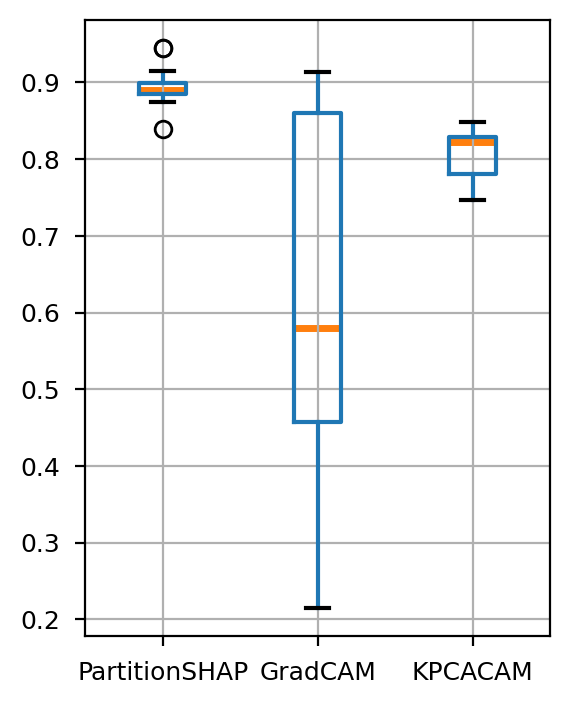

CON : adv_attk_sim : SR


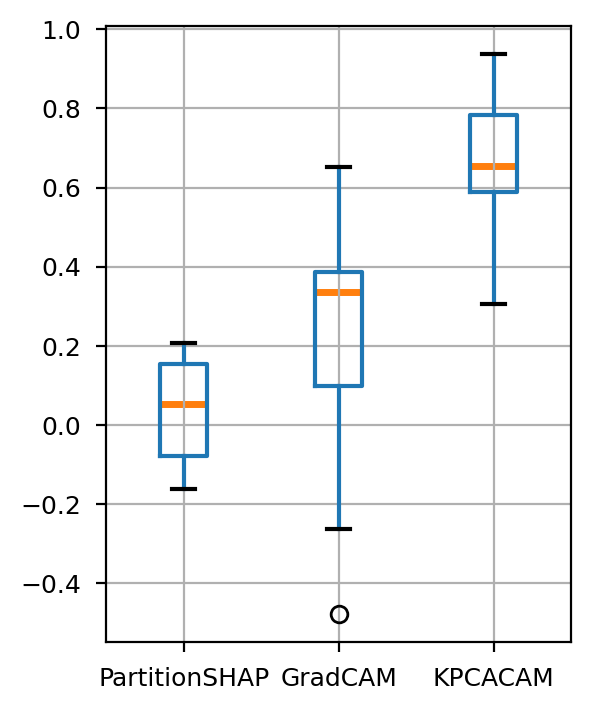

CON : adv_attk_sim : ssim


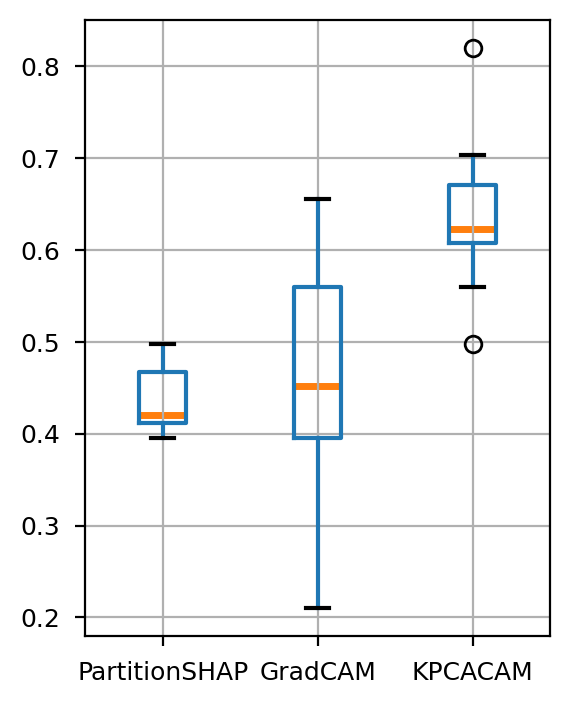

CON : adv_attk_sim : top_m


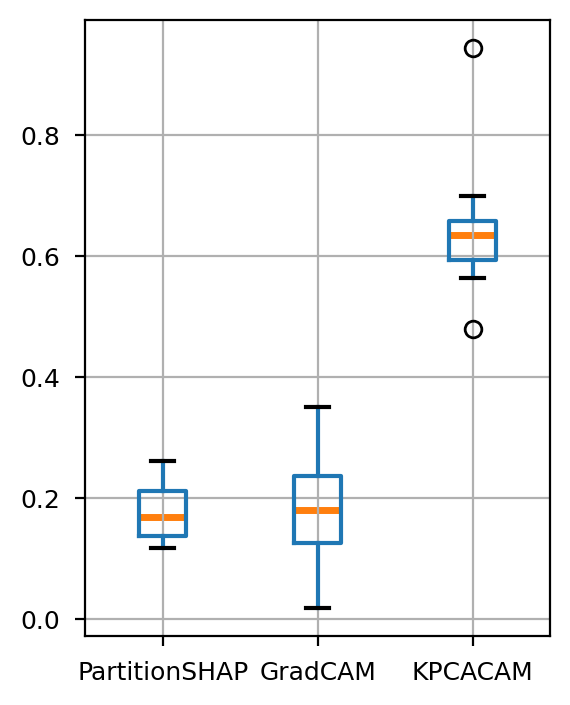

COR : incremental_deletion_auc_ratio


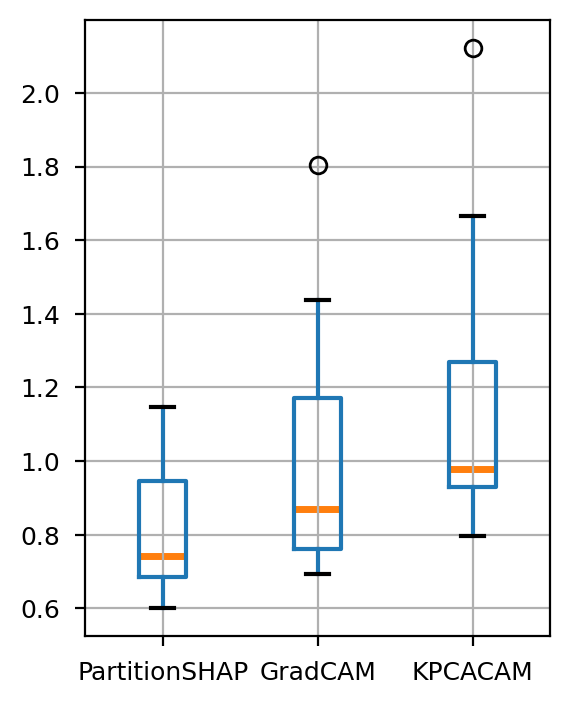

COR : random_sim : SR


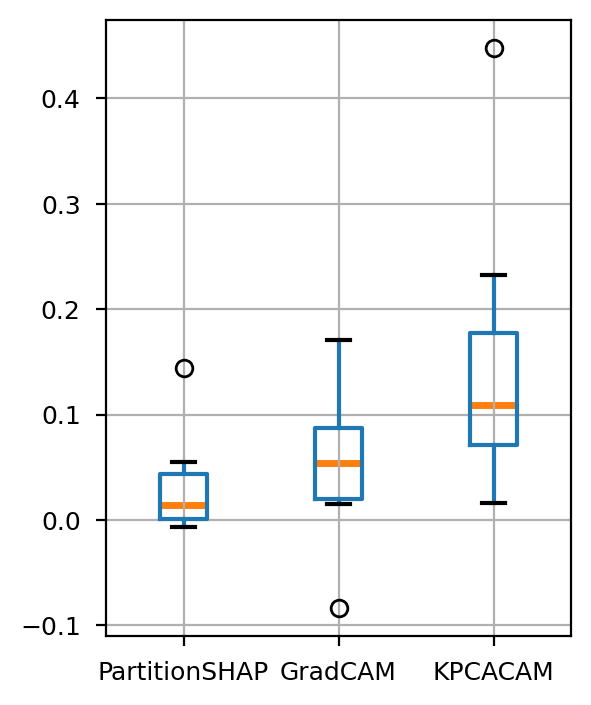

COR : random_sim : ssim


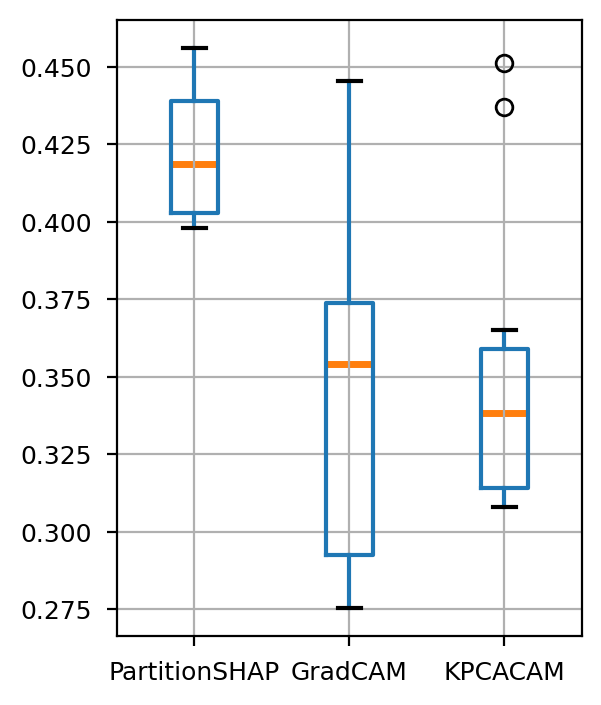

COR : random_sim : top_m


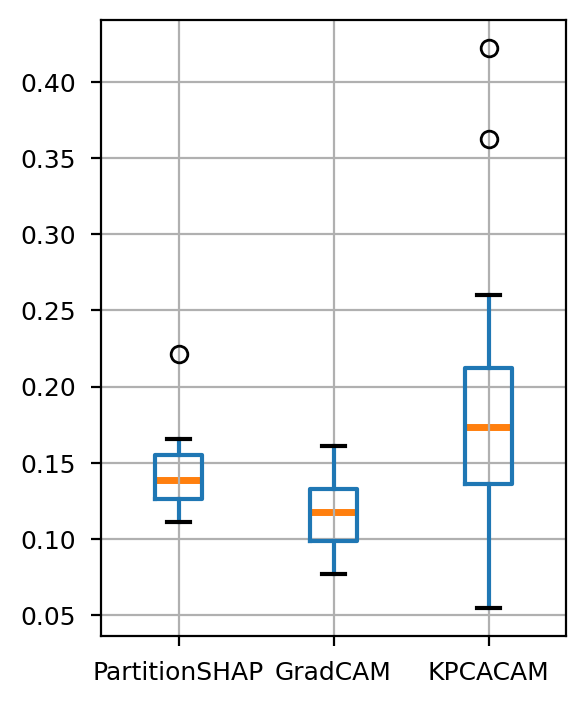

O-C : deletion_check_conf_drop


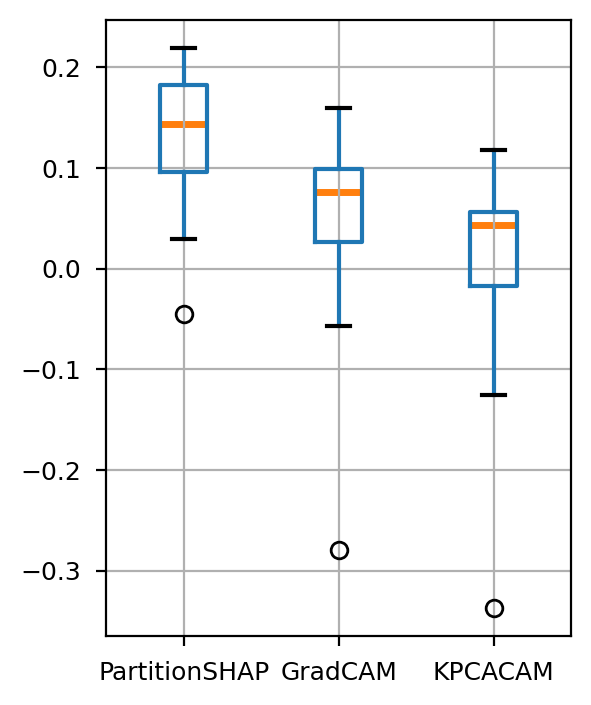

O-C : preservation_check_conf_drop


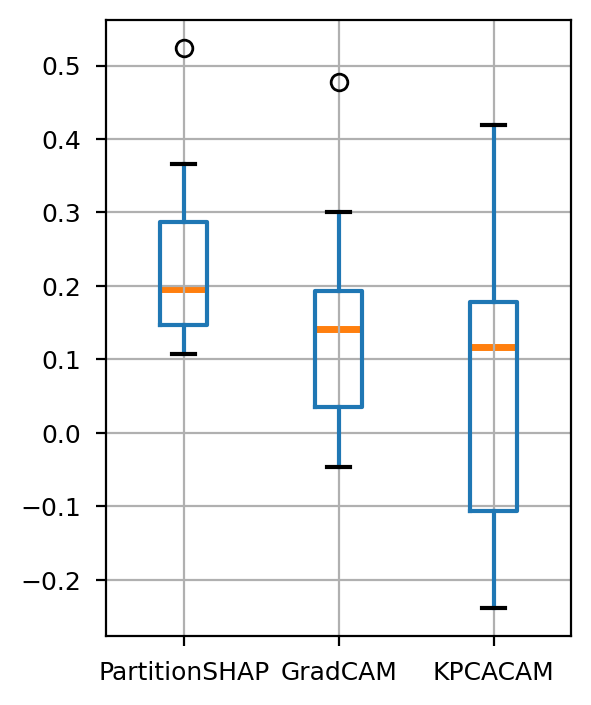

In [10]:
for group_name, df in metric_grouped_df:
    print(group_name)
    df = df[[df.columns[i] for i in [2, 0, 1]]]
    median_style = dict(color='C1', linestyle='-', linewidth=2.5, zorder=-1)
    line_style = dict(color='C0', linestyle='-', linewidth=1.5)
    whisker_style = dict(color='C0', linestyle='-', linewidth=1.5)
    tail_style = dict(color='k', linestyle='-', linewidth=1.5, zorder=10)
    df.boxplot(rot=0, figsize=(3, 4), fontsize=9,
               medianprops=median_style, boxprops=line_style, whiskerprops=whisker_style, capprops=tail_style)
    plt.gcf().set_dpi(200)
    plt.show()

#### Summary writeup

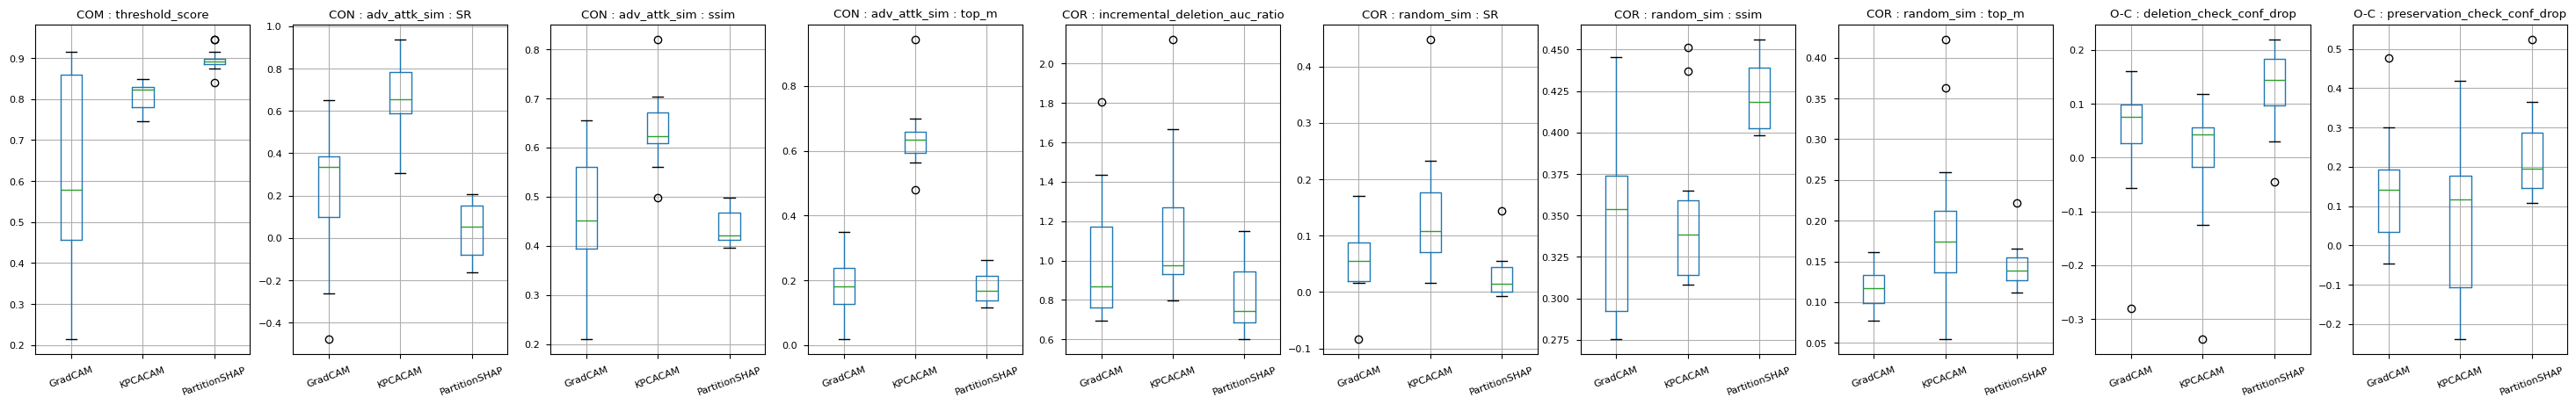

In [11]:
# all together in one row
metric_grouped_df.boxplot(rot=20, subplots=True, sharey=False, layout=(1, 10), figsize=(36,5))
plt.show()

**Correctness (COR) : randomised similarity** - Apart from in the SSIM metric (since structurally, PartitionSHAP explanation can be quite similar),  KPCA-CAM has higher Spearman's rank and top-m intersection, increasing suspicions of a non-faithful explanation. But since this is just a sanity check, we're not too interested in comparing the values, rather just confirming that the similarity is not too high. PartitionSHAP has a very consistently low rank and top-m intersection as does GradCAM, but KPCA is more inconsistent.

**Correctness (COR) : incremental deletion auc ratio** - PartitionSHAP has the smallest spread with most (at least 75%) combinations better than random deletion (ratio below 1). Both CAM methods work well for half the combinations but have high variability for the other half, performing far worse than random (ratio above 1).

**Output-Completeness (O-C) : deletion check** - PartitionSHAP performs the best out of a bad bunch but its one worse case where it is worse than random (less than 0) is much better than the CAM methods which both perform much worse than random. In over half of cases, all manage to be better than random but the CAM methods by much less. This metric is difficult - see discussion below.

**Output-Completeness (O-C) : preservation check** - Overall all methods perform better on this metric.  However, KPCA is very variable depending on the dataset and model combination with a very large range of over 0.6, especially compared to PartitionSHAP and GradCAM with <0.3 and <0.4 respectively.

**Contrastivity (CON) : adversarial similarity** - KPCA explanations for adversarial examples remain similar to the original explanation for all model/dataset combinations across all 3 metrics - this is not a good indication. GradCAM explanations vary from being somewhat similar to not similar at all with high variability over all 3 metrics. Only PartitionSHAP is consistently dis-similar from the original explanations across all three metrics: important regions are rarely correlated or overlap between different classes, suggesting contrastive explanations are produced.

**Compactness (COM) : threshold score** - PartitionSHAP is consistently the most compact in all cases, followed by KPCACAM (as designed) whereas GradCAM is extremely variable (not compact for SwinT, somewhat for ResNet, and compact for ConvNeXt).

#### Per metric, graph of datapoints used to calculate boxplots

You can match up the outliers exactly using these charts with the one above.

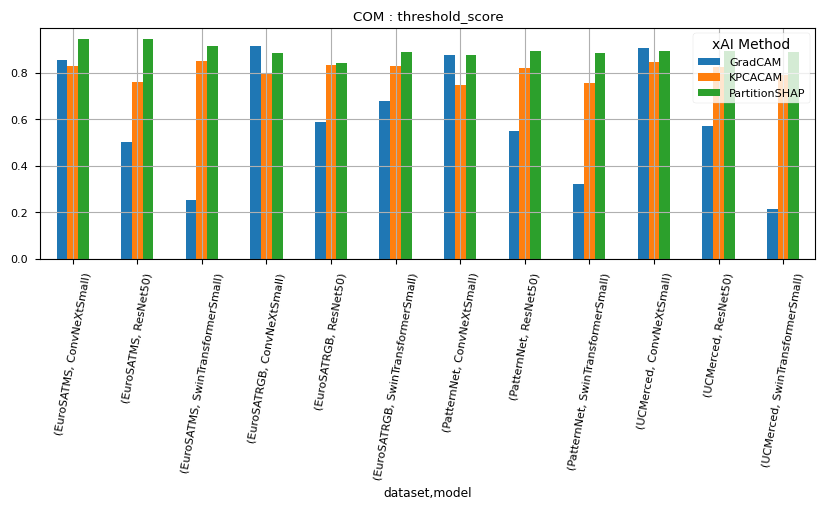

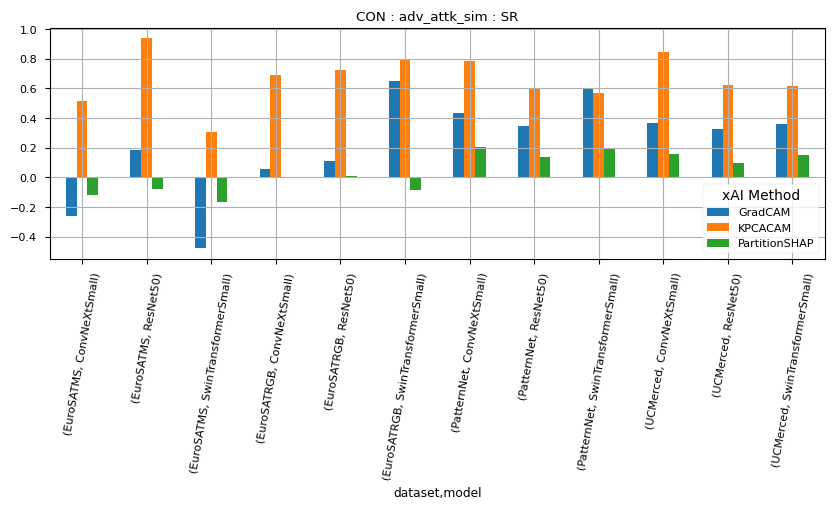

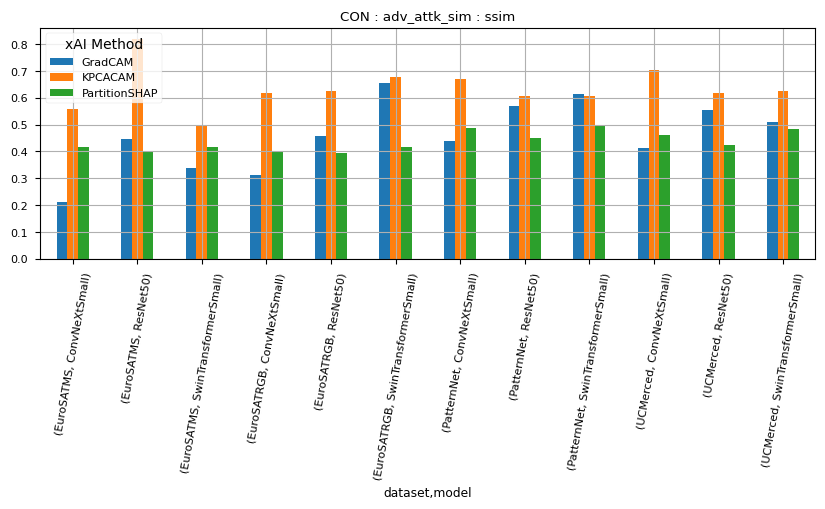

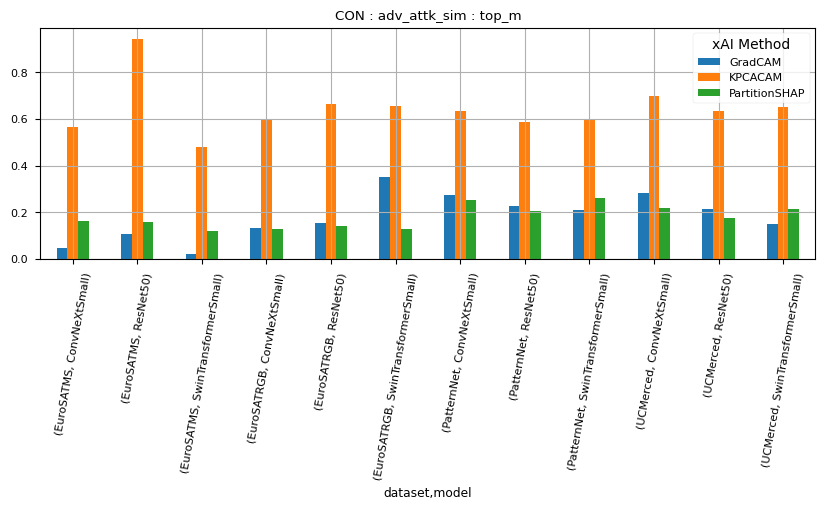

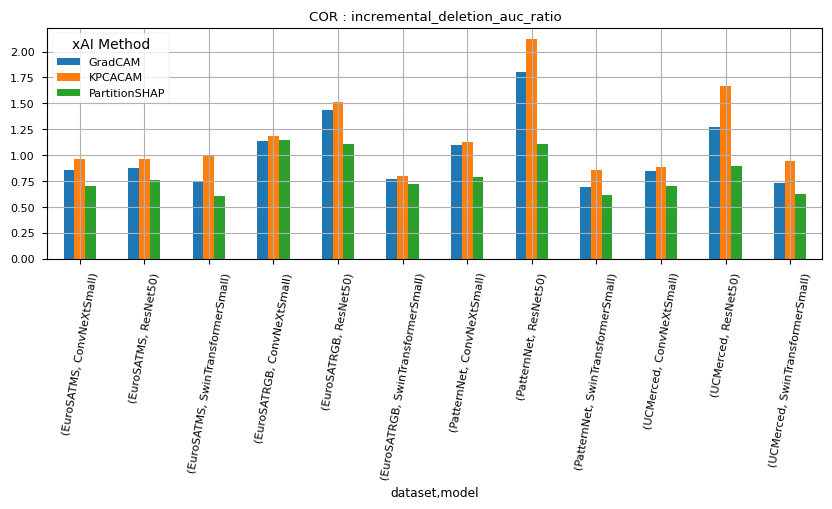

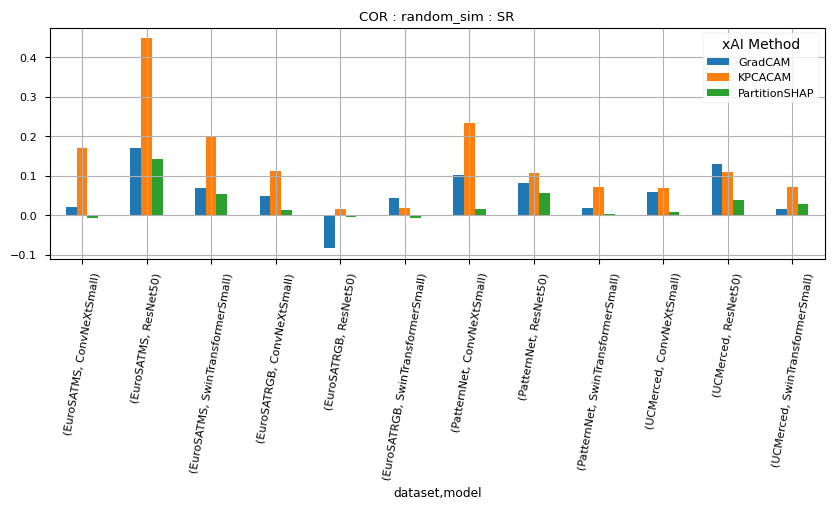

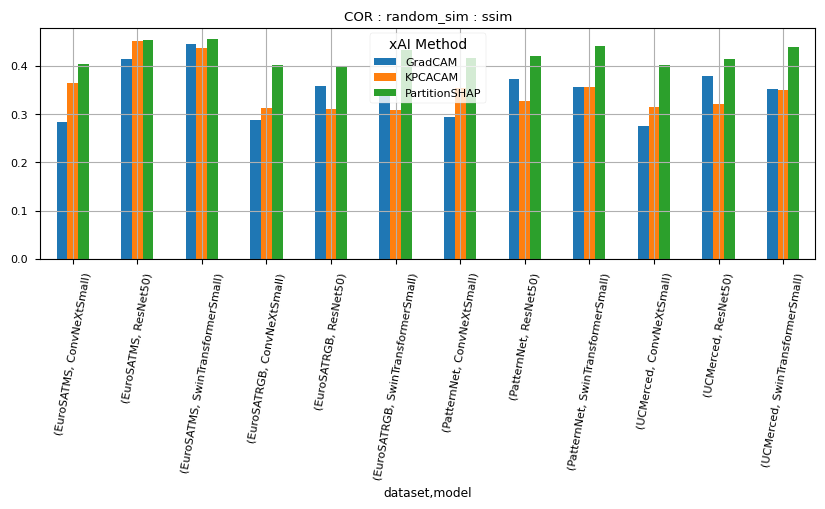

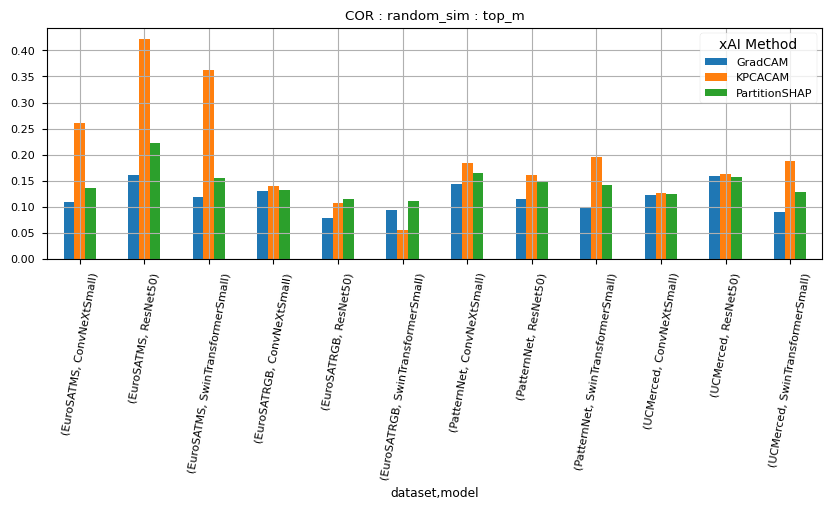

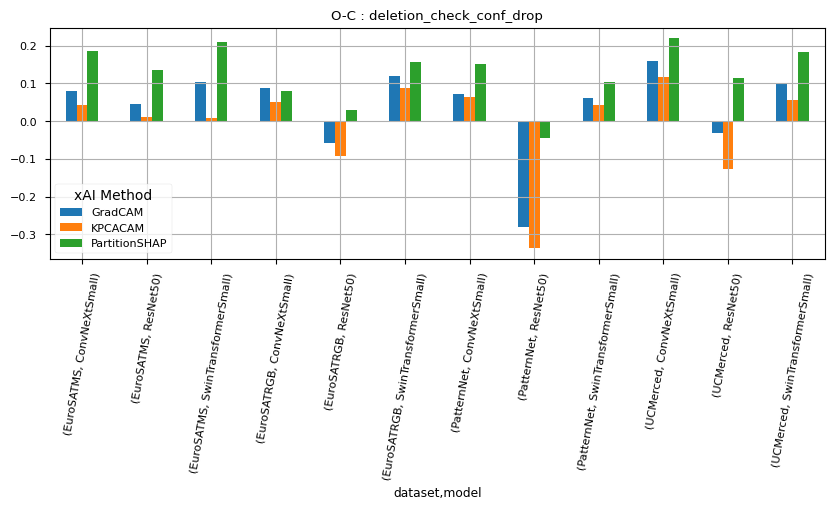

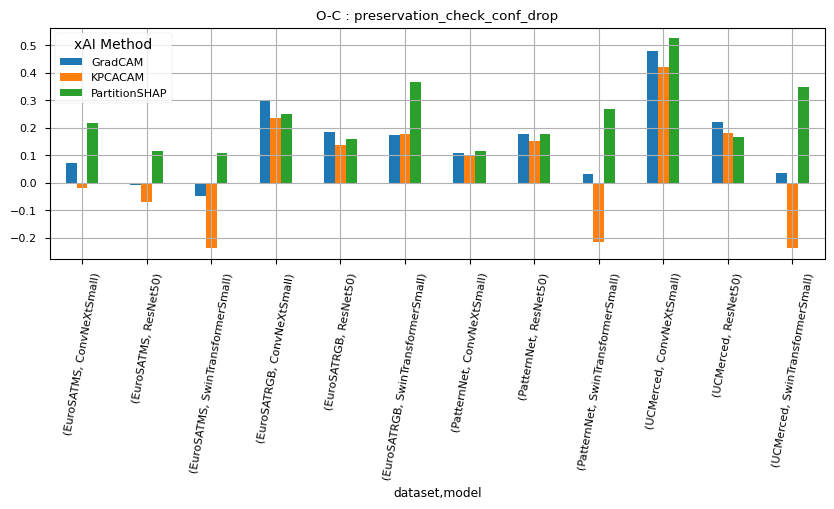

In [12]:
for col in metric_grouped_df.median().index:  # use the grouped_df from above to get the same order as box plots
    col_mean = xai_ds_m_c_df[col].reset_index(level=0).pivot(columns="xai_method").groupby(["dataset", "model"]).mean()
    # get rid of the metric name (since we've selected only that col anyway) from the multiindex
    col_mean.columns = [n[1] for n in col_mean.columns]
    col_mean.plot(kind="bar", rot=80, figsize=(10, 3), title=col, grid=True)
    plt.legend(title="xAI Method")  #, loc="upper right", bbox_to_anchor=(1.1, 1.1))
    plt.show()

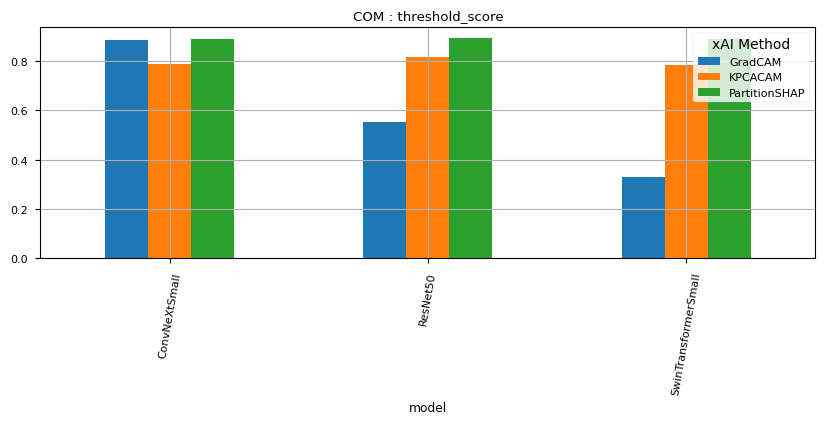

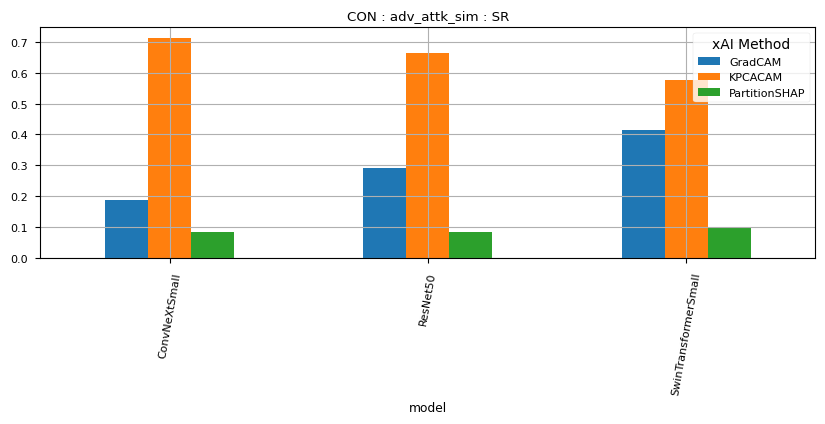

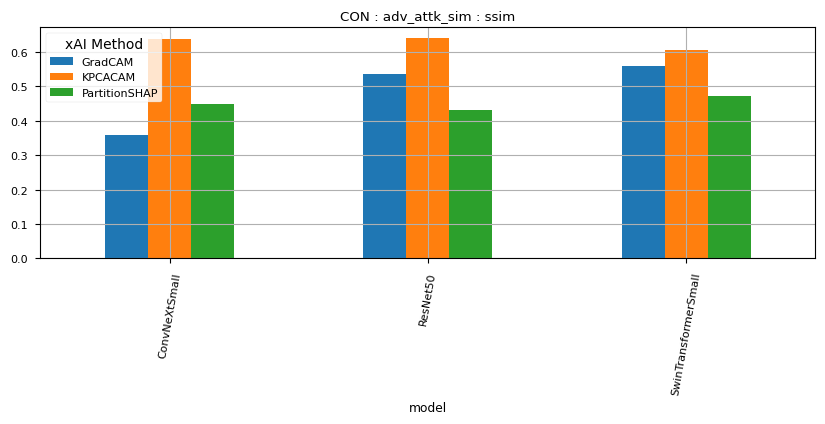

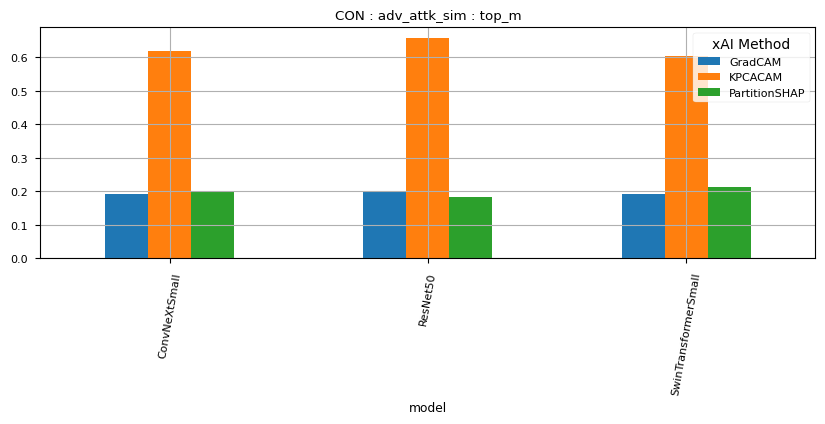

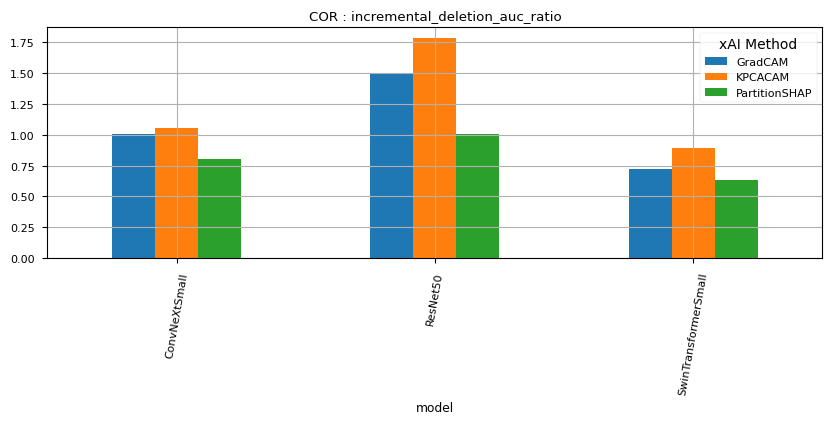

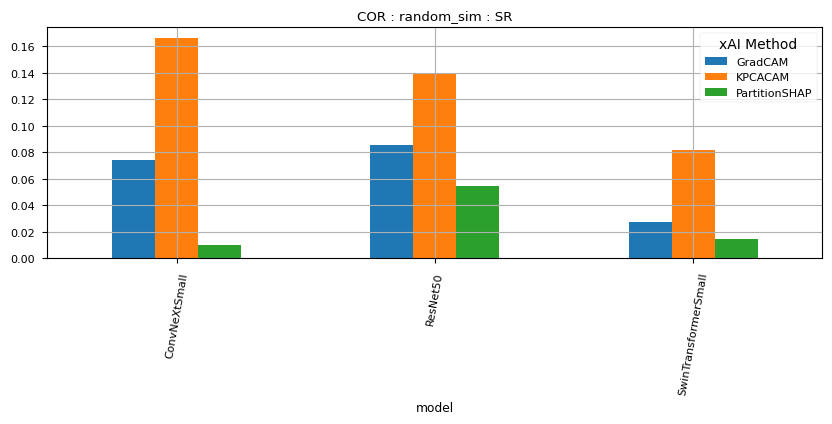

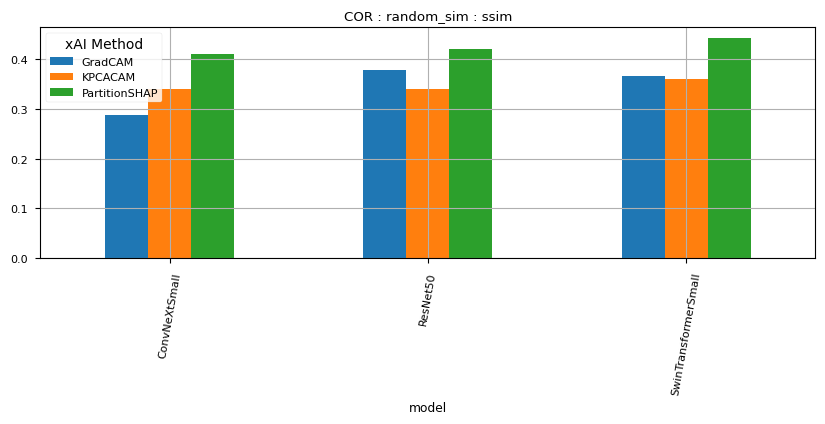

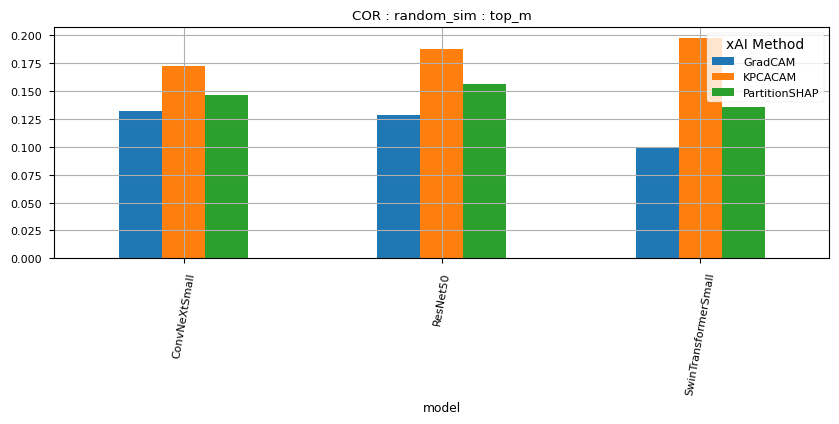

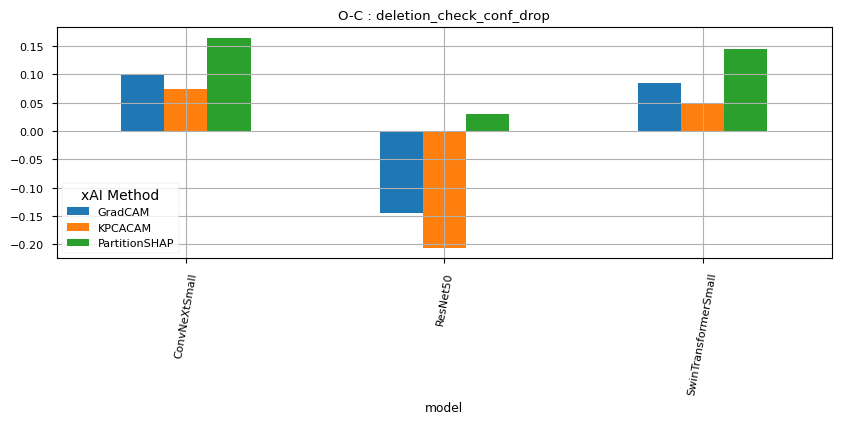

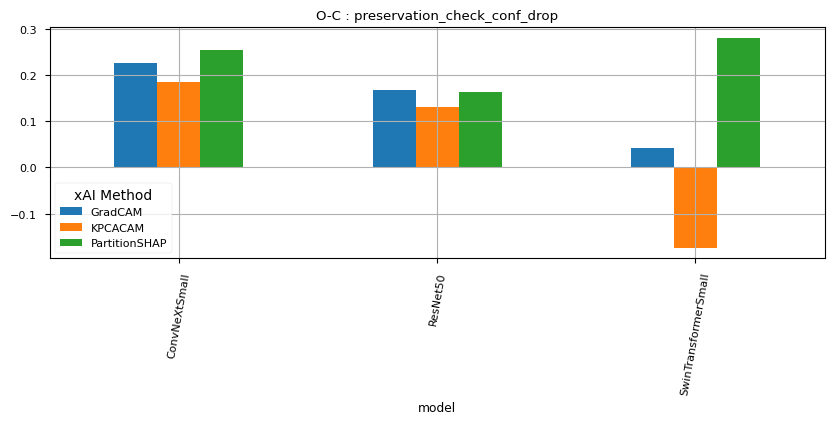

In [13]:
for col in metric_grouped_df.median().index:  # use the grouped_df from above to get the same order as box plots
    col_mean = xai_ds_m_c_df[col].reset_index(level=0).pivot(columns="xai_method").groupby(["model"]).mean()
    # get rid of the metric name (since we've selected only that col anyway) from the multiindex
    col_mean.columns = [n[1] for n in col_mean.columns]
    col_mean.plot(kind="bar", rot=80, figsize=(10, 3), title=col, grid=True)
    plt.legend(title="xAI Method")  #, loc="upper right", bbox_to_anchor=(1.1, 1.1))
    plt.show()

# Sanity check correctness (random_sim)

We want this to be low across all 3 similarity metrics if the explanation accurately reflects the model's behaviour.

In [ ]:
cor_rs_cols = xai_ds_m_c_df.columns[xai_ds_m_c_df.columns.str.contains("COR : random_sim")]
cor_rs_df: pd.DataFrame = xai_ds_m_c_df[cor_rs_cols]
cor_rs_df.head(10)

In [ ]:
cor_rs_df.groupby(level=["xai_method", "dataset"]).mean().plot(kind="bar", rot=70, grid=True)
plt.show()

KPCA seems suspicious here on EuroSATMS

In [ ]:
cor_rs_df.loc["KPCACAM", "EuroSATMS"].groupby("model").mean().plot(kind="bar", rot=0, grid=True)
plt.show()

Suggests that KPCACAM is not a faithful explainer for ResNet50 on EuroSATMS.

In [ ]:
cor_rs_df.loc["KPCACAM", "EuroSATMS", "ResNet50"].plot(kind="bar", rot=40, grid=True)
plt.show()

Appears to be worst for River and SeaLake

# Correctness (incremental_deletion_auc_ratio)

We want this to be low (but might vary a lot by dataset and classes depending on object/land type) with 0 best and above 1 means random deletion was better.

In [ ]:
cor_id_cols = xai_ds_m_c_df.columns[xai_ds_m_c_df.columns.str.contains("COR : incremental_deletion_auc_ratio")]
cor_id_df: pd.DataFrame = xai_ds_m_c_df[cor_id_cols]
cor_id_df.columns

In [ ]:
def colour_code_high_bars(threshold):
    ax = plt.gca()

    ax.axhline(threshold, color="r", linestyle="--")

    # Get all bar containers in the current plot
    containers = [c for c in ax.containers]
    heights = [p.get_height() for c in containers for p in c.patches]

    for container in containers:
        for patch in container.patches:
            height = patch.get_height()
            if height > threshold:
                # Calculate intensity based on how much it exceeds the threshold
                # Capping at 0.9 to avoid completely black bars
                ratio = max((height - threshold) / (max(heights) - threshold), 0.2)
                # Create a darker shade of red the higher the value
                color = (1.0, 1.0 - ratio, 1.0 - ratio)
                patch.set_facecolor(color)

### Hardest dataset classes

In [ ]:
for e_name in t.get_args(xai.EXPLAINER_NAMES):
    cor_id_df.loc[e_name].groupby(level=["dataset", "class_label"]).mean().plot(kind="bar", figsize=(20, 5), title=e_name)
    colour_code_high_bars(1)
    plt.show()

In [ ]:
cor_id_df.groupby(level=["dataset", "class_label"]).describe()

In EuroSATMS, SeaLake was the hardest class to delete important pixels (many adversarial examples also moved to this class) - makes sense: large area with similar colours. But also generally did well in MS across the board.

In EuroSATRGB: AnnualCrop, likely for similar reasons. Pasture and Permanent Crop also.

PatternNet: river the hardest but specifically for CAM methods. PartitionSHAP didn't struggle to identify. Swimming pool also hard for all.

UCMerced: runway and river (and to some extent beach).

In [ ]:
cor_id_df.loc[:, "PatternNet", :, "river"]

## Are the other two good for any datasets at all?

In [ ]:
cor_id_df.reset_index(level=0).pivot(columns="xai_method").groupby(["dataset"]).mean().plot(kind="bar", rot=0, figsize=(15, 5), title="Hardest datasets by xai method of incremental deletion")
plt.axhline(1, color="r")

PatternNet was the hardest for GradCAM and KPCACAM with only PartitionSHAP getting sub 1 across all datasets.

In [ ]:
cor_id_df.groupby(["xai_method", "dataset"]).describe()

All methods seem better than random for EuroSATMS deletion. PatternNet is hard for GradCAM and KPCACAM.

## Or good for any models?

In [ ]:
cor_id_df.reset_index(level=0).pivot(columns="xai_method").groupby(["model"]).mean().plot(kind="bar", rot=0, figsize=(10, 5), title="Models that xai methods struggled with")
plt.axhline(1, color="r")

In [ ]:
cor_id_df.groupby(["xai_method", "model"]).describe()

All are actually worst for ResNet with the highest mean and std (can also be seen in graph above)?? Especially for GradCAM and KPCACAM.
And consistently (low std) best on the SwinTransformer with by far the least bad worst case.

In [ ]:
cor_id_df.reset_index(level=0).pivot(columns="xai_method").groupby(["dataset", "model"]).mean().plot(kind="bar", rot=80, figsize=(10, 5), title="Models that xai methods struggled with", grid=True)
plt.axhline(1, color="r")

## Overall reliability

In [ ]:
cor_id_df.groupby("xai_method").describe()

PartitionSHAP is the most reliable with a sub 1 incremental deletion ratio and lowest std. The UQ (75%) is also < 1.

In [ ]:
cor_id_df[cor_id_df>=1].groupby("xai_method").count() / len(cor_id_df.loc["PartitionSHAP"])

KPCACAM is only slightly better than random overall at identifying important pixels.

# Output-Completeness (deletion_check_conf_drop & preservation_check_conf_drop)

We want this to be high with the best score being 1. Worst possible in both cases is -1.

In [ ]:
oc_dp_cols = xai_ds_m_c_df.columns[xai_ds_m_c_df.columns.str.contains("O-C")]
oc_dp_df: pd.DataFrame = xai_ds_m_c_df[oc_dp_cols].rename(columns={"O-C : deletion_check_conf_drop": "Del", "O-C : preservation_check_conf_drop": "Pres"})
oc_dp_df.columns

In [ ]:
oc_dp_df.groupby("xai_method").boxplot(rot=90, subplots=True, layout=(1, 3))

On average, all are bad with a lot of variability. PartitionSHAP is slightly better.

In [ ]:
oc_dp_df_by_class_mean = oc_dp_df.groupby(["dataset", "class_label"]).mean()
oc_dp_df_by_class_mean.plot(kind="bar", rot=90, figsize=(25, 7), grid=True, subplots=False)
plt.suptitle("Hard classes for all explainers on all models")

The easiest classes across the datasets to delete pixels from are EuroSAT-highway, PatternNet-intersection, UCM-airplane, sparse residential, storage tanks, and tennis court.
Perhaps because these are scenes where objects are localised to specific areas where important pixels can be easily deleted. In other classes, nearest neighbour in filling might result in such similar colours that the model still believes them to be present.
PatternNet's freeway, baseball field (this class is easier to preserve) and river classes are very hard to delete though.

For preserving pixels, EuroSAT-highway remains easy, PatternNet-golf course and harbour, UCM-airplane, baseball diamond, beach, sparse residential, storage tanks and tennis court.
Since the surroundings are important for these as well, we theorise that classes can more easily change if these surrounding pixels are deleted.

## Investigate performance class by class for each explainer

In [ ]:
for e_name in t.get_args(xai.EXPLAINER_NAMES):
    oc_dp_df.loc[e_name].groupby(["dataset", "class_label"]).mean().plot(kind="bar", rot=90, figsize=(25, 7), grid=True, subplots=False, title=e_name)
    plt.show()

PartitionSHAP manages a positive score across almost all classes.

In [ ]:
(oc_dp_df.loc["KPCACAM"].groupby(["dataset", "class_label"]).mean() - oc_dp_df_by_class_mean).plot(kind="bar", rot=90, figsize=(25, 7), grid=True, subplots=False)
plt.suptitle("KPCACAM - average")

KPCACAM is worse than average in virtually every class for both metrics.

## Explainer efficacy on different models

In [ ]:
oc_dp_df.groupby(["xai_method", "model"]).boxplot(rot=90, figsize=(20, 7), subplots=False)
plt.suptitle("Model robustness")

Deleting pixels rarely flipped ResNets.

In [ ]:
oc_dp_df.groupby(["xai_method", "model"]).describe()

ResNet explanations are very difficult to delete from. SwinTransformer is hard to preserve for CAM methods. ConvNeXt somewhat explainable by all and for specific classes can do very well.

### For specific datasets

In [ ]:
oc_dp_df.loc[:, "UCMerced", "ConvNeXtSmall"].plot(kind="bar", rot=90, figsize=(20, 7), subplots=False, grid=True)

The same classes are consistently difficult across all explanation methods. For some specific classes, all methods are successful at identifying important (e.g. PatternNet tennis court)

In [ ]:
for m in AVAILABLE_MODELS:
    oc_dp_df.loc[:, "PatternNet", m].plot(kind="bar", rot=90, figsize=(20, 7), subplots=False, grid=True, title=m)
    plt.show()

For PatternNet, best explanations are for ConvNeXt across all explainers. KPCA struggles to preserve the correct areas for the SwinTransformer.

In [ ]:
for m in AVAILABLE_MODELS:
    oc_dp_df.loc[:, "UCMerced", m].plot(kind="bar", rot=90, figsize=(20, 7), subplots=False, grid=True, title=m)
    plt.show()

For UCMerced again, ConvNeXt easiest to explain. CAM methods struggle to delete from ResNet (small convolutions make it sensitive to small regions changing?). KPCACAM can't preserve for SwinT (large attention based tokens mean it considers the whole image?)

# Contrastivity (adversarial_attack_similarity)

We want this to be low with the best score being 0. Worst case is +1. A negative spearman's rank means the opposite pixels are relevant which is kind of what we expect for an adversarial attack.

In [ ]:
con_cols = xai_ds_m_c_df.columns[xai_ds_m_c_df.columns.str.contains("CON")]
con_df: pd.DataFrame = xai_ds_m_c_df[con_cols].copy()
con_df.columns

### Examine and remove lots of N/A instances

In [ ]:
print(con_df["CON : adv_attk_sim : SR"].loc["GradCAM"].isna().groupby(level=["model", "dataset"]).sum())

ConvNeXt on PatternNet couldn't generate adv examples on 20/38 classes.
On UCMerced, " on 16/21. Too robust to generate adversarial examples. Skip these two for evaluation.

In [ ]:
con_df.drop(index=[(e, "PatternNet", "ConvNeXtSmall") for e in t.get_args(xai.EXPLAINER_NAMES)], inplace=True)
con_df.drop(index=[(e, "UCMerced", "ConvNeXtSmall") for e in t.get_args(xai.EXPLAINER_NAMES)], inplace=True)

In [ ]:
print(con_df["CON : adv_attk_sim : SR"].loc["GradCAM"].isna().groupby(level=["model", "dataset"]).sum())

In [ ]:
for e_name in t.get_args(xai.EXPLAINER_NAMES):
    con_df.loc[e_name].groupby(level=["model", "dataset"]).mean().plot(kind="bar", rot=90, figsize=(20, 7), subplots=False, grid=True, title=e_name)
    plt.show()

In [ ]:
# Same chart as above but combined into one row
con_df.groupby(level=["xai_method", "model", "dataset"]).mean().plot(kind="bar", rot=90, figsize=(20, 7), subplots=True, grid=True)

KPCA show much higher similarity scores across all three metrics on all models and datasets. PartitionSHAP's explanations score higher on SSIM metrics (maybe because they are more targeted/sparse and also because satellite imagery covers large areas which are themselves similar) but other metrics are lower as expected.
GradCAM struggles with SwinTransformer (except EuroSATMS) the most and is least contrastive for EuroSATRGB.

PartitionSHAP is very consistent across different models and datasets (as expected for a completely model agnostic method) - see stds below also. Overall, it does best across all metrics and datasets with GradCAM not far behind.

In [ ]:
for col in con_df.columns:
    print("\n", col)
    print(con_df[col].groupby(level=["xai_method"]).describe())

## Comparing model performance

In [ ]:
mean_by_model = con_df.reset_index(level=0).pivot(columns="xai_method").groupby(level=["model"]).mean()
mean_by_model.sort_index(axis=1, level=1).plot(kind="bar", grid=True, subplots=False, figsize=(9, 5), rot=0)
plt.legend(loc='upper center', ncols=3, bbox_to_anchor=(0.5, 1.2))

For GradCAM and PartitionSHAP, difficulty goes (easiest) ConvNeXt -> ResNet -> SwinT (hardest).

For KPCA, (easiest) Conv -> SwinT -> ResNet (hardest)

## Similarity metrics by dataset

In [ ]:
mean_by_dataset = con_df.reset_index(level=0).pivot(columns="xai_method").groupby(level=["dataset"]).mean()
mean_by_dataset.sort_index(axis=1, level=1).plot(kind="bar", grid=True, subplots=False, figsize=(9, 5), rot=0)
plt.legend(loc='upper center', ncols=3, bbox_to_anchor=(0.5, 1.2))

In [ ]:
# The same chart exploded into one chart per metric instead of combined
for col in con_df.columns:
    con_df.reset_index(level=0).pivot(columns="xai_method")[col].groupby(level=["dataset"]).mean().plot(kind="bar", grid=True, subplots=False, title=col)

The top m most important pixels barely change when informed by KPCA across all datasets.

PatternNet hard for CAM methods by all 3 metrics.

GradCAM appears to be better than SHAP on EuroSATMS, SHAP better on RGB variant. SHAP has less channel information to go on whereas the activation gradients in GradCAM might change completely for adversarial examples (by design)

In [ ]:
for ds_n in set(con_df.index.get_level_values("dataset")):
    print("\n", ds_n)
    con_df.loc[:, ds_n, :].reset_index(level=0).pivot(columns="xai_method").groupby("class_label").mean().sort_index(axis=1, level=1).plot(kind="bar", rot=90, figsize=(10, 5), grid=True, subplots=False, title=ds_n)
    plt.legend(loc='upper center', ncols=3, bbox_to_anchor=(0.5, 1.2))
    plt.show()

# Compactness (threshold_score)

We want this to be high indicating a high proportion of the pixels under the threshold

Is this even valid for RS images where there are large regions which are relevant? so large portions of the image *should* be above the threshold?

In [ ]:
com_cols = xai_ds_m_c_df.columns[xai_ds_m_c_df.columns.str.contains("COM")]
com_df: pd.DataFrame = xai_ds_m_c_df[com_cols].copy()
com_df.columns

In [ ]:
com_df.groupby("xai_method").describe()

This reflects what KPCA was designed for: more localised and compact explanations than GradCAM.

In [ ]:
com_df.reset_index(level=0).pivot(columns="xai_method").groupby(["model"]).mean().plot(kind="bar")

PartitionSHAP is consistent across methods (since it's attributions approximately sum to output) as is KPCACAM.

GradCAM becomes less compact for ResNet and then even more populous for SwinTransformer - it can't focus on a few points and just highlights the whole image.

In [ ]:
com_df.reset_index(level=0).pivot(columns="xai_method").groupby(["dataset"]).mean().plot(kind="bar")

In [ ]:
com_df.reset_index(level=0).pivot(columns="xai_method").groupby(["dataset", "model"]).mean().plot(kind="bar")


GradCAM does notably better on EuroSAT. Others do similarly on all datasets.